In [3]:
import pandas as pd

In [4]:
#### Data import



# read data

reviews_df = pd.read_csv("Hotel_Reviews.csv")
# append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
# create the label
reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df.head()

print(reviews_df.loc[0]['review'])

reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)

reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))


#### Data cleaning


from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

import string
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    # print(text)
    pos_tags = pos_tag(text)
    # lemmatize text
    # print(pos_tags)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
#     for t in pos_tags:
#         # print(t)
#         text=[WordNetLemmatizer().lemmatize(t[0],get_wordnet_pos(t[1]))]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # print(text)
    # join all
    text = " ".join(text)
    return(text)

# clean text data
# text_df = reviews_df.head(10)
# text_df["review_clean"]= text_df["review"].apply(lambda x: clean_text(x))

reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

reviews_df.head()

#### Feature Engineering


import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)


reviews_df.head()

# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

reviews_df.head(2)


 I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the room and after explaining 2 times that i booked a duplex btw it costs the same as a simple double but got way more volume due to the high ceiling was offered a room but only the next day SO i had to check out the next day before 11 o clock in order to get the room i waned to Not the best way to begin yo

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


ModuleNotFoundError: No module named 'gensim'

In [5]:
reviews_df.head(5)

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7


In [6]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]
# print(type(documents))

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=8)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
print(type(doc2vec_df))
print(doc2vec_df.head())
# doc2vec_df.head(10)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

print(documents[1:10])
doc2vec_df.head(10)
reviews_df.head(10)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

reviews_df.head()




<class 'pandas.core.frame.DataFrame'>
               0         1         2         3         4
488440  0.006332  0.304843 -0.210925 -0.023313 -0.539744
274649  0.002067  0.017236  0.022567 -0.049623 -0.013338
374688  0.144719  0.034983  0.118400 -0.131461 -0.019596
404352  0.011571  0.133722 -0.002055  0.031259  0.138882
451596  0.041143  0.113556  0.010268 -0.077808 -0.000395
[TaggedDocument(words=['tissue', 'paper', 'box', 'present', 'room'], tags=[1]), TaggedDocument(words=['pillow', 'nice', 'welcome', 'service'], tags=[2]), TaggedDocument(words=['everything', 'include', 'nice', 'upgrade', 'hotel', 'revamp', 'surprise', 'love', 'every', 'second', 'include', 'room', 'dining', 'excellent'], tags=[3]), TaggedDocument(words=['lovely', 'hotel', 'welcome', 'staff'], tags=[4]), TaggedDocument(words=['free', 'wifi', 'location', 'perfect', 'lot', 'time', 'want', 'look', 'city', 'centre'], tags=[5]), TaggedDocument(words=['room', 'generally', 'bit', 'shabby', 'lack', 'maintenance', 'crumb', '

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_yet,word_yoghurt,word_yogurt,word_young,word_yr,word_yummy,word_zero,word_ziggo,word_zone,word_zuid
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113,0.006332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10,0.002067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7,0.144719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27,0.011571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7,0.041143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


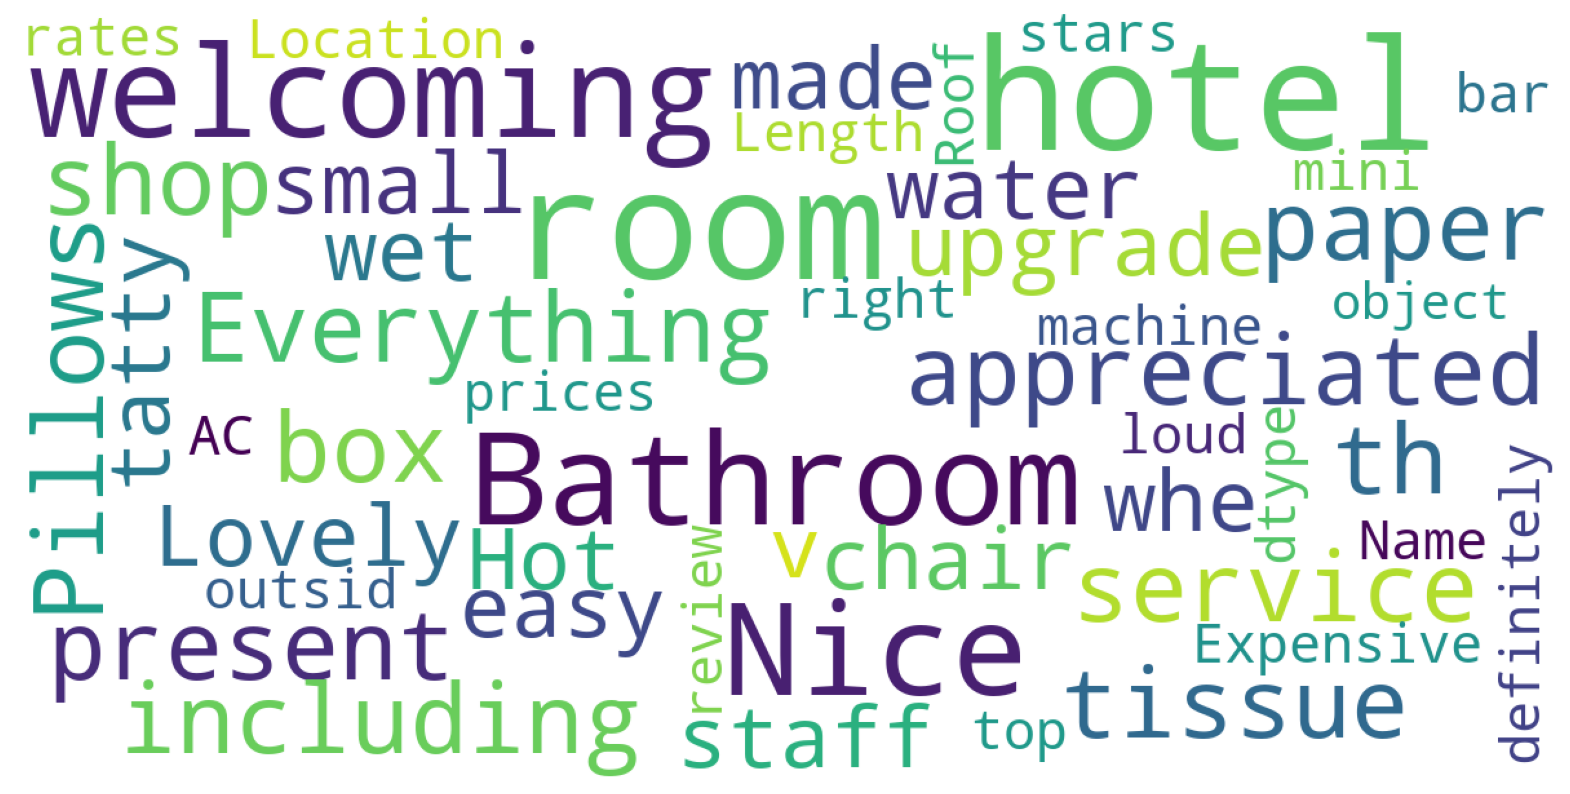

ModuleNotFoundError: No module named 'seaborn'

In [7]:
#### EDA

reviews_df["is_bad_review"].value_counts(normalize = True)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
#         min_words = 50,
        max_words=250,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)



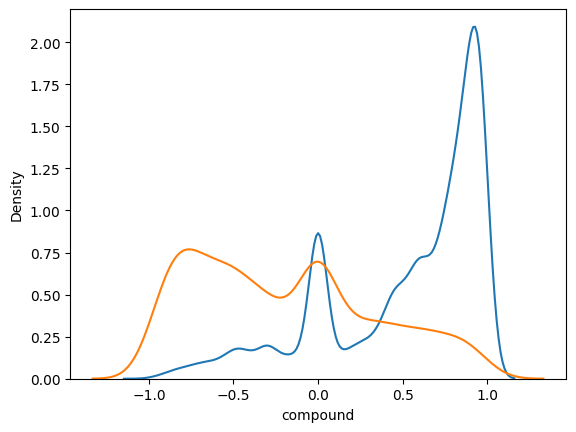

In [9]:
import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.kdeplot(subset['compound'], label = label)


In [10]:
#####  Model creation

label = "is_bad_review"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)
# cv_scores_grid = cross_val_score(grid, reviews_df[features], reviews_df[label], cv=15)
print(X_test.shape)
print(y_test.shape)
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)
print(f'accuracy of train set: {rf.score(X_train, y_train)}')
print(f'accuracy of test set: {rf.score(X_test, y_test)}')

y_predicted=rf.predict_proba(X_test)
# print(type(y_predicted))
# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)


(10315, 3837)
(10315,)
accuracy of train set: 0.9999515257277201
accuracy of test set: 0.9566650508967524


,feature,importance
3,compound,0.038524
6,doc2vec_vector_0,0.024773
2,pos,0.024586
0,neg,0.022547
8,doc2vec_vector_2,0.019354
10,doc2vec_vector_4,0.018025
4,nb_chars,0.016644
7,doc2vec_vector_1,0.016517
9,doc2vec_vector_3,0.016443
5,nb_words,0.014770


In [28]:
y_test.head(5)
y_test_fin=y_test.reset_index(drop = True)
y_test_fin.head(5)
y_test_array = y_test_fin.to_numpy()
y_test_fin.shape
# y_predicted.shape

(10315,)

In [30]:



from sklearn.metrics import roc_auc_score

y_predicted_array = y_predicted[:, 1]
# Assuming y_true contains true labels and y_pred contains predicted probabilities or scores
roc_auc = roc_auc_score(y_test_array, y_predicted_array)

print("ROC AUC Score:", roc_auc)



ROC AUC Score: 0.8896261888962619


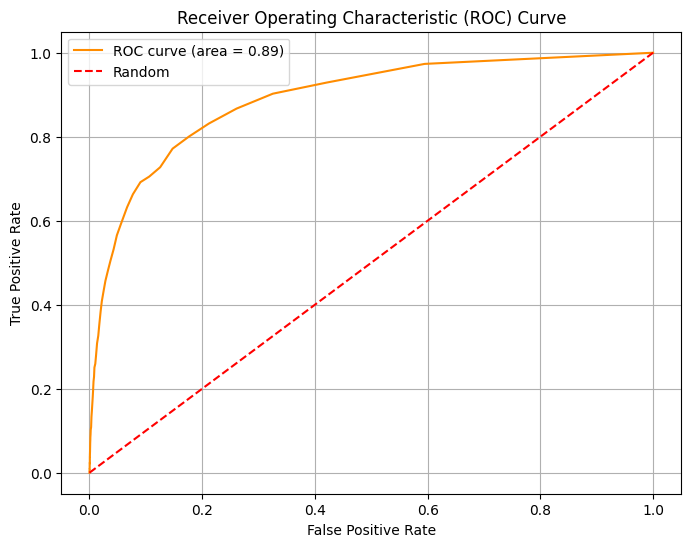

In [36]:
from sklearn.metrics import roc_curve,auc

fpr, tpr, thresholds = roc_curve(y_test_array, y_predicted_array)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()